## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)


## Setup and Imports

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random
from datasets import load_dataset
import sklearn

In [3]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [6]:
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

## Importing Data

In [7]:
dataset = load_dataset("emotion")

In [10]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [11]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [13]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

In [14]:
tweets, labels = get_tweet(train)

In [21]:
x = 5
tweets[x], labels[x]

('ive been feeling a little burdened lately wasnt sure why that was', 0)

## Tokenizing tweets

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [25]:
tokenizer = Tokenizer(num_words = 10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [30]:
x = 5
print(tweets[x])
print(tokenizer.texts_to_sequences([tweets[x]]))

ive been feeling a little burdened lately wasnt sure why that was
[[73, 48, 8, 7, 56, 521, 319, 328, 158, 161, 9, 20]]


## Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

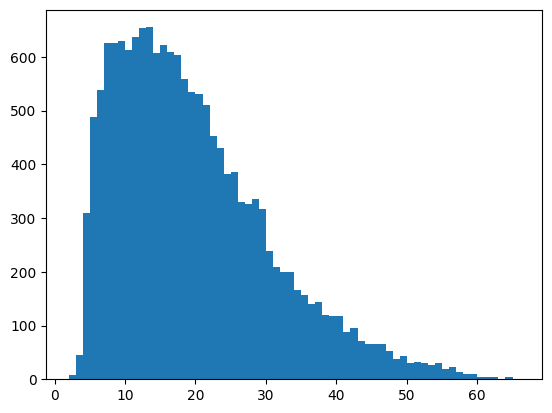

In [32]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [33]:
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [34]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
  return padded

In [35]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [39]:
x = 0
print(tweets[x])
print(padded_train_seq[x])

i didnt feel humiliated
[  2 139   3 679   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


## Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [40]:
classes = set(labels)
print(classes)

{0, 1, 2, 3, 4, 5}


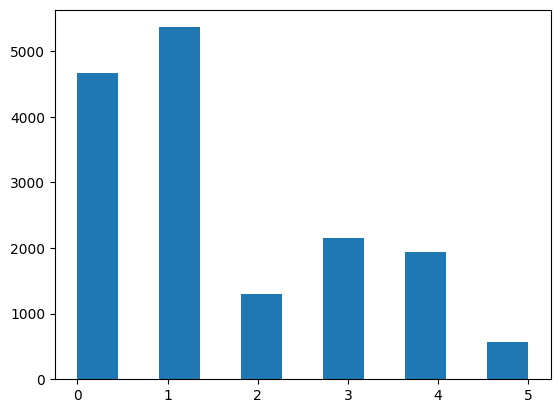

In [41]:
plt.hist(labels, bins=11)
plt.show()

In [48]:
emotions = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
index_to_class = {i: label for i, label in enumerate(emotions)}
class_to_index = dict((c,i) for i,c in enumerate(classes))


In [46]:
index_to_class

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

In [49]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [50]:
train_labels = names_to_ids(labels)
print(train_labels[0])

0


## Creating the Model

1. Creating the model
2. Compiling the model

In [51]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_shape=(maxlen,)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

c:\Users\alvar\anaconda3\envs\ML-practices\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [52]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 16)         │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 40)         │         5,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 40)             │         9,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           246 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 175,926 (687.21 KB)

 Trainable params: 175,926 (687.21 KB)

 Non-trainable params: 0 (0.00 B)

## Training the Model

1. Preparing a validation set
2. Training the model

In [53]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [54]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon',
 np.int64(0))

In [55]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data = (val_seq, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.4154 - loss: 1.3970 - val_accuracy: 0.6190 - val_loss: 0.9907
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.7464 - loss: 0.7015 - val_accuracy: 0.8055 - val_loss: 0.5807
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8744 - loss: 0.3901 - val_accuracy: 0.8550 - val_loss: 0.4812
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9206 - loss: 0.2645 - val_accuracy: 0.8675 - val_loss: 0.4523
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9362 - loss: 0.2003 - val_accuracy: 0.8800 - val_loss: 0.3875
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9491 - loss: 0.1556 - val_accuracy: 0.8775 - val_loss: 0.3995
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9581 - loss: 0.1296 - val_accuracy: 0.8860 - val_loss: 0.3869
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9669 - loss: 0.1009 - 

## Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

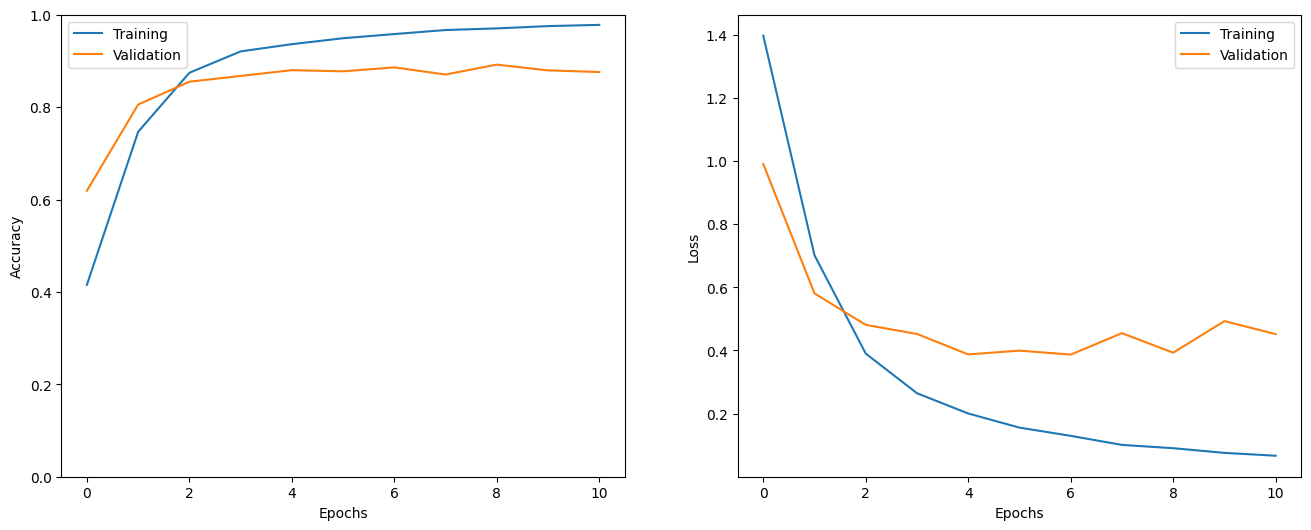

In [56]:
show_history(h)

In [57]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [58]:
_ = model.evaluate(test_seq, test_labels)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8695 - loss: 0.4706


In [67]:
i = random.randint(0, len(test_labels)-1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion:', pred_class)

Sentence: i feel cared for and accepted
Emotion: love
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Emotion: love


In [68]:
pred_probs = model.predict(test_seq)
preds = np.argmax(pred_probs, axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


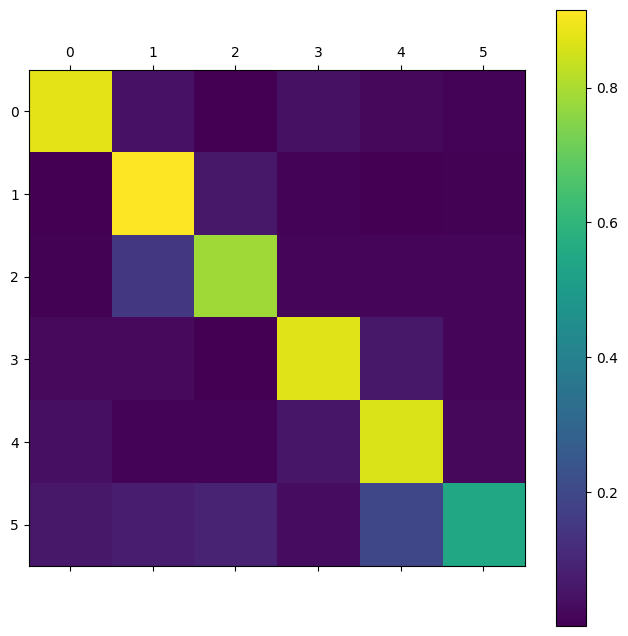

In [69]:
show_confusion_matrix(test_labels, preds, list(classes))